# 🧠 Trenowanie i porównanie modeli YOLO w zadaniu detekcji odpadów

## 1. Cel projektu

Celem projektu było:
- wytrenowanie modelu detekcji obiektów typu **YOLO**,
- analiza wpływu jakości danych treningowych oraz liczby epok na jakość modelu,
- porównanie dwóch modeli:
  - **Model A** – trenowany na gorszej jakości zdjęciach i mniejszej liczbie epok,
  - **Model B** – trenowany na lepszej jakości danych i większej liczbie epok.

Projekt dotyczy zadania **detekcji odpadów (Garbage Detection)** na obrazach.

## 2. Opis wykorzystanych modeli

W projekcie wykorzystano architekturę **YOLO11n**, trenowaną w środowisku Python z użyciem biblioteki **Ultralytics YOLO**.

### 2.1 Model A – model słabiej wytrenowany

Model A:
- trenowany na zbiorze danych o **niższej jakości obrazów **(240x240px),
- trenowany przez **mniejszą liczbę epok **(300),
- charakteryzuje się:
  - niższym recall,
  - większą liczbą fałszywych detekcji,
  - gorszą lokalizacją obiektów.

### 2.2 Model B – model lepiej wytrenowany

Model B:
- trenowany na **lepszym jakościowo zbiorze danych** (640x640px),
- trenowany przez **większą liczbę epok **(100),
- charakteryzuje się:
  - wyższym recall i precision,
  - lepszym dopasowaniem bounding boxów,
  - stabilniejszymi predykcjami.

## 3. Środowisko eksperymentalne

Eksperymenty przeprowadzono z wykorzystaniem biblioteki **Ultralytics YOLO**.

**Ważne zastrzeżenie metodologiczne:**
- **Trening:** Modele były trenowane w różnych środowiskach sprzętowych (Model A lokalnie na Apple Silicon (M4 Pro), Model B w chmurze na GPU), dlatego w raporcie **nie porównujemy czasu trwania treningu**, gdyż byłoby to niemiarodajne.
- **Ewaluacja (Inference):** Wszystkie testy przedstawione w tym notatniku (predykcja, pomiar czasu reakcji) zostały wykonane na **tej samej maszynie (Apple M1 Pro)**, co zapewnia uczciwe porównanie wydajności gotowych modeli.

## 4. Wczytanie bibliotek

In [32]:
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from IPython.display import Image, display
import matplotlib.image as mpimg

%matplotlib inline

## 5. Wczytanie wytrenowanych modeli

In [33]:
# Model A – słabiej wytrenowany
model_poor = YOLO("GARBAGE CLASSIFICATION 3/runs/detect/train/weights/best.onnx")

# Model B – lepiej wytrenowany
model_good = YOLO("yolo11n run/runs/detect/train/weights/best.onnx")


## 6. Test modeli na wykonanym przez nas obrazie


In [34]:
image_path = "resources/glass.jpg"

## 7.1 Predykcja – Model A (słabiej wytrenowany)

In [35]:
results_poor = model_poor(image_path)
results_poor[0].show()

Loading GARBAGE CLASSIFICATION 3/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 CPUExecutionProvider

image 1/1 /Users/cyprianciesielski/PycharmProjects/GarbageClassification/resources/glass.jpg: 320x320 1 GLASS, 1 METAL, 14.6ms
Speed: 2.4ms preprocess, 14.6ms inference, 2.1ms postprocess per image at shape (1, 3, 320, 320)


Obserwacje:
- model praktycznie nie wykrywa obiektów
- mozliwe błędne detekcje

## 7.2 Predykcja – Model B (lepiej wytrenowany)

In [36]:
results_good = model_good(image_path)
results_good[0].show()

Loading yolo11n run/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 CPUExecutionProvider

image 1/1 /Users/cyprianciesielski/PycharmProjects/GarbageClassification/resources/glass.jpg: 640x640 1 GLASS, 40.6ms
Speed: 3.1ms preprocess, 40.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Obserwacje:
- model poprawnie wykrywa obiekt
- większa pewność predykcji

## 8. Analiza zbioru danych (Dataset Statistics)
Weryfikacja rozkładu klas oraz rozmieszczenia obiektów w zbiorze treningowym. Nierównowaga klas może wpływać na to, że model faworyzuje najczęstsze obiekty.

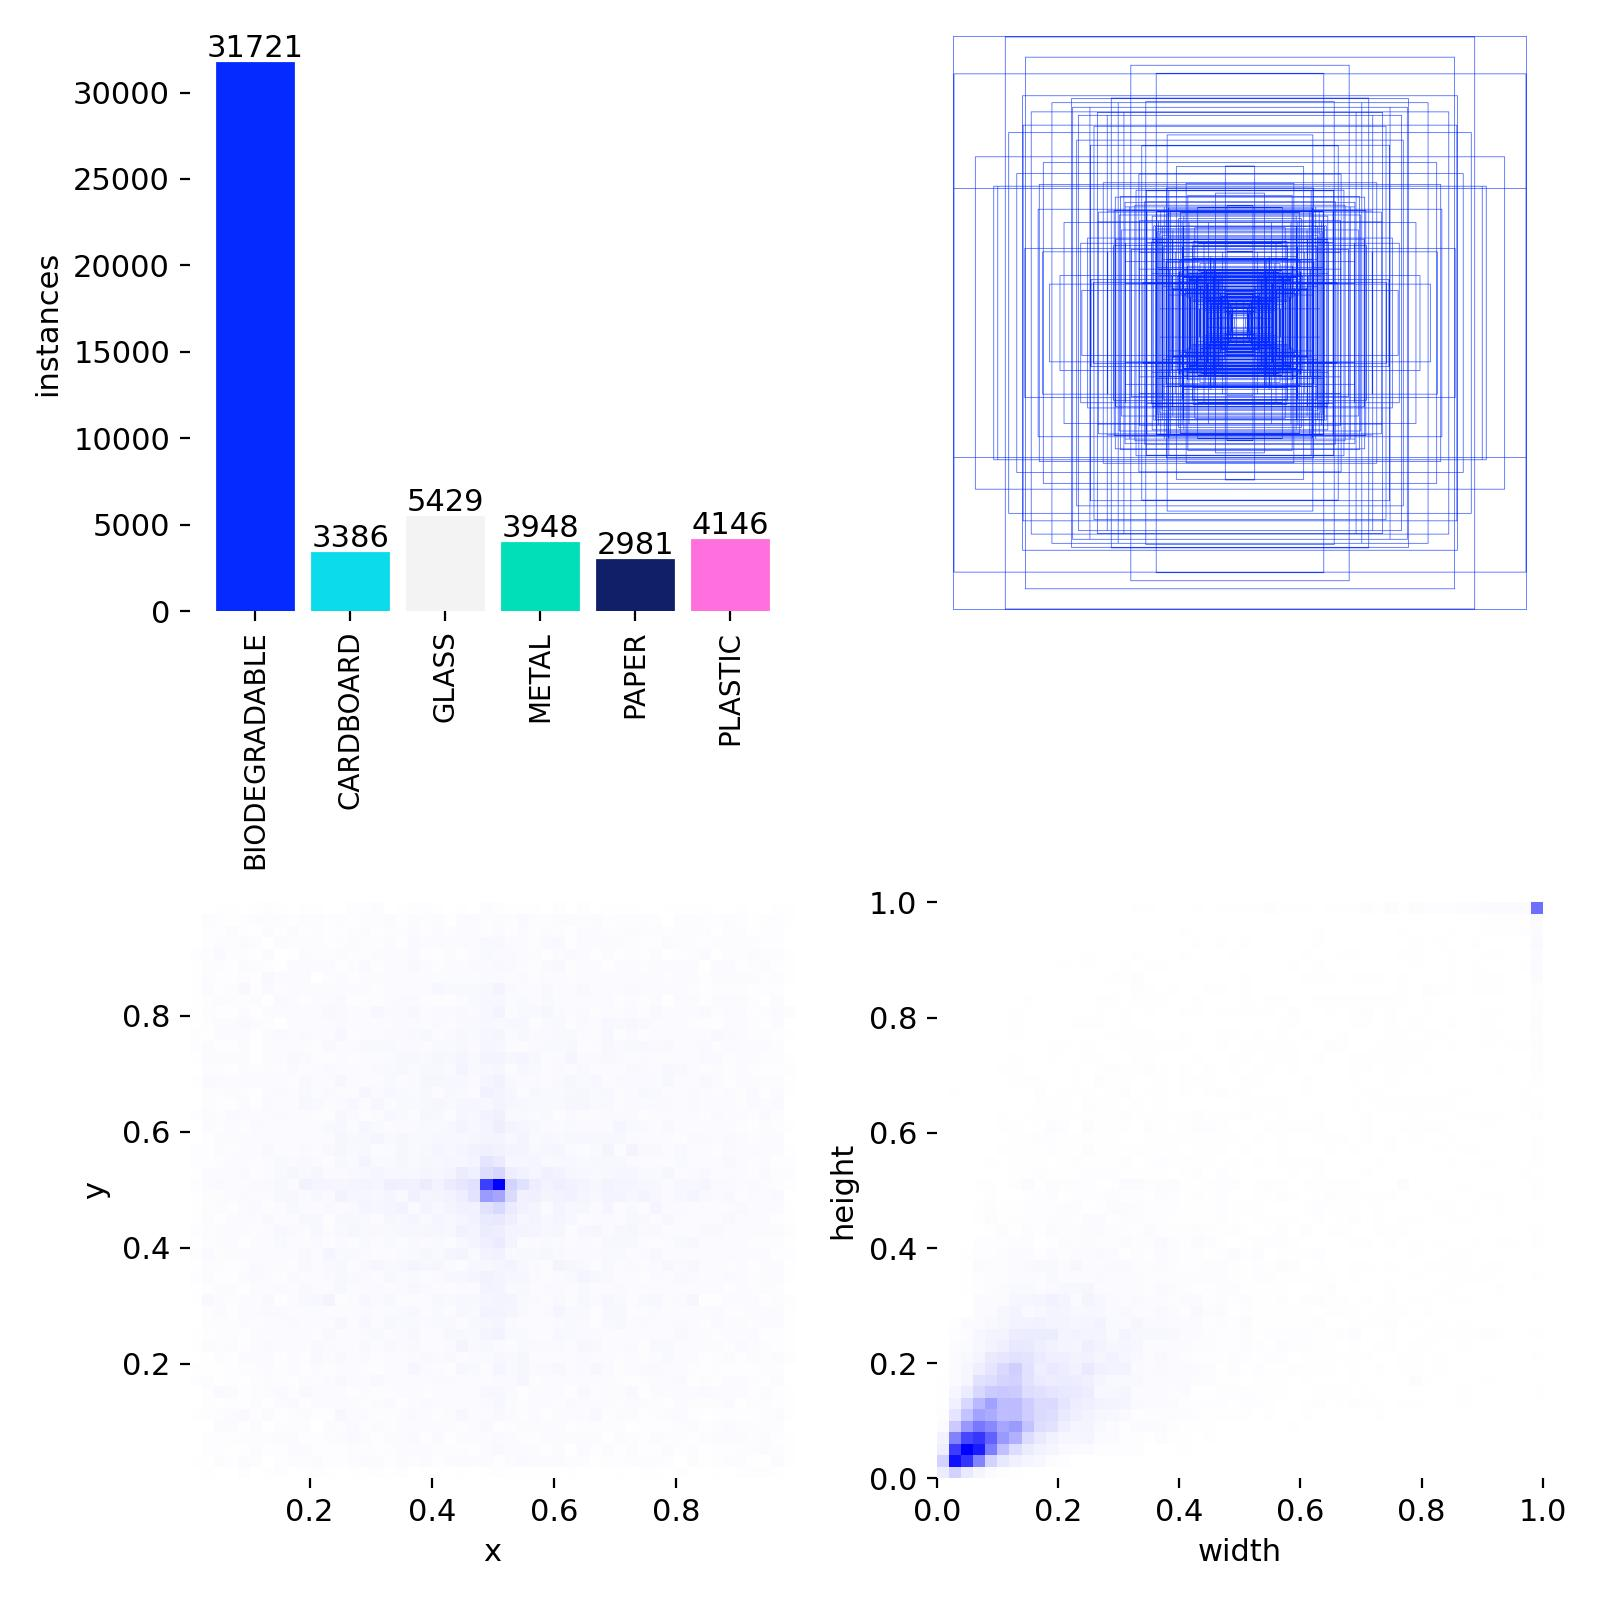

In [37]:
labels_path = "yolo11n run/runs/detect/train/labels.jpg"

if os.path.exists(labels_path):
    display(Image(filename=labels_path, width=800))
else:
    print("Nie znaleziono pliku statystyk danych (labels.jpg).")

## 9. Bezpośrednie porównanie wizualne (Side-by-Side)
Zestawienie wyników detekcji dla obu modeli na tym samym obrazie.

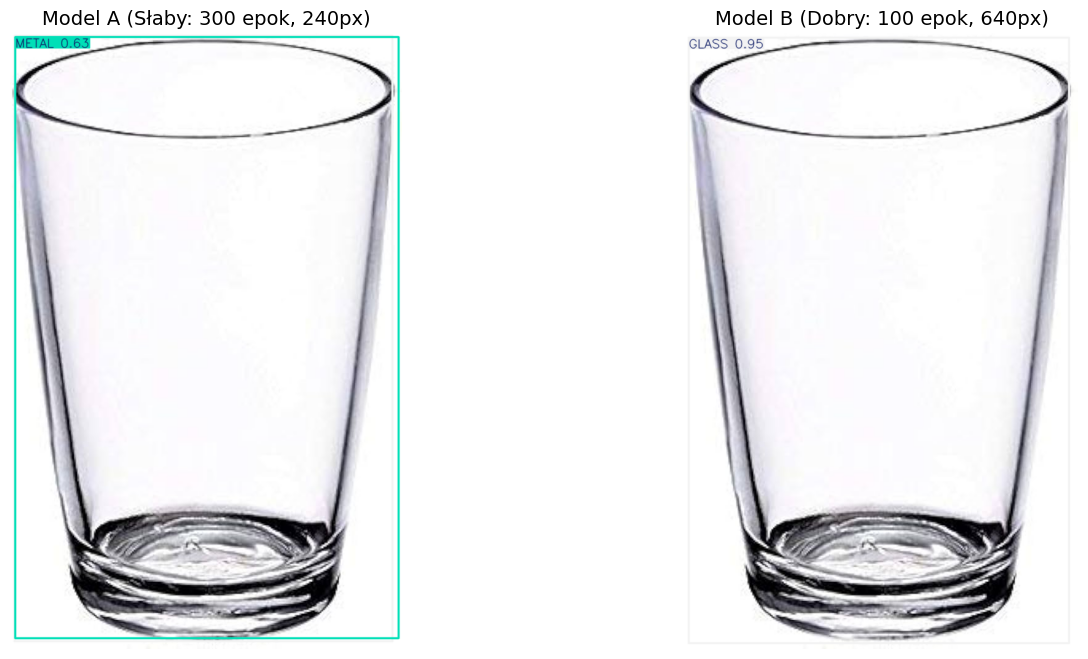

In [38]:
def plot_side_by_side(res_a, res_b, title_a, title_b):
    # Generowanie obrazów z ramkami (plot() zwraca tablicę BGR)
    img_a = res_a[0].plot()
    img_b = res_b[0].plot()

    # Konwersja BGR na RGB dla matplotlib
    img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)
    img_b = cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB)

    # Ustawienie wykresów
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    axes[0].imshow(img_a)
    axes[0].set_title(title_a, fontsize=14)
    axes[0].axis('off')

    axes[1].imshow(img_b)
    axes[1].set_title(title_b, fontsize=14)
    axes[1].axis('off')

    plt.show()

# Wywołanie funkcji dla naszych wyników
plot_side_by_side(results_poor, results_good,
                  "Model A (Słaby: 300 epok, 240px)",
                  "Model B (Dobry: 100 epok, 640px)")

## 10. Analiza przebiegu treningu
Porównanie postępów uczenia na podstawie plików logów `results.csv`.

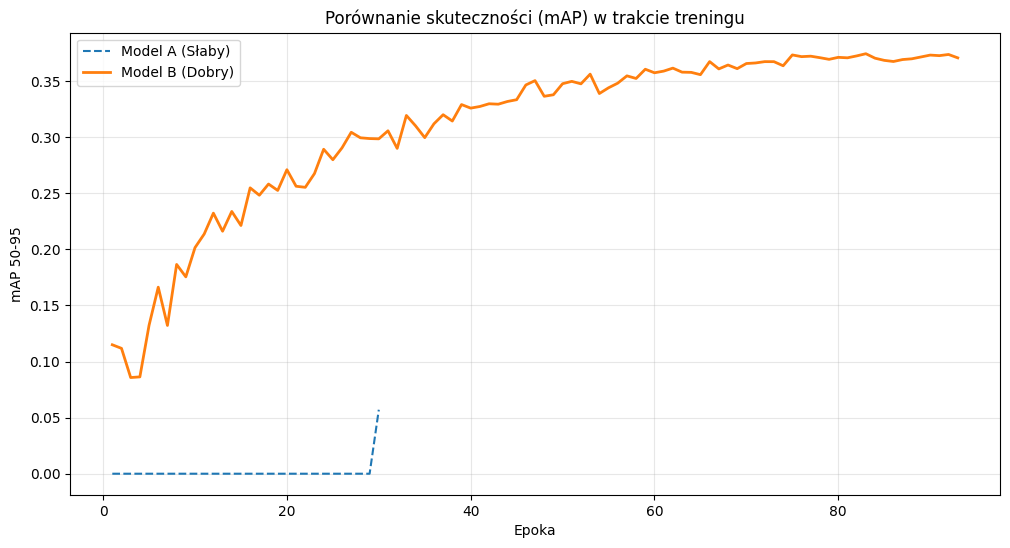

In [39]:
# Ścieżki do plików CSV (na podstawie Twoich folderów)
path_poor = "GARBAGE CLASSIFICATION 3/runs/detect/train/results.csv"
path_good = "yolo11n run/runs/detect/train/results.csv"

try:
    # Wczytanie danych
    df_poor = pd.read_csv(path_poor)
    df_good = pd.read_csv(path_good)

    # Usunięcie spacji z nazw kolumn (YOLO czasem dodaje spacje)
    df_poor.columns = df_poor.columns.str.strip()
    df_good.columns = df_good.columns.str.strip()

    # Rysowanie wykresów mAP50-95
    plt.figure(figsize=(12, 6))
    plt.plot(df_poor['epoch'], df_poor['metrics/mAP50-95(B)'], label='Model A (Słaby)', linestyle='--')
    plt.plot(df_good['epoch'], df_good['metrics/mAP50-95(B)'], label='Model B (Dobry)', linewidth=2)

    plt.xlabel('Epoka')
    plt.ylabel('mAP 50-95')
    plt.title('Porównanie skuteczności (mAP) w trakcie treningu')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

except FileNotFoundError:
    print("Nie znaleziono plików results.csv. Sprawdź czy ścieżki do folderów 'runs/' są poprawne.")

## 11. Analiza błędów-Macierz Pomyłek (Confusion Matrix)
Poniżej przedstawiono macierze pomyłek wygenerowane automatycznie pod koniec procesu trenowania. Pozwalają one ocenić, które klasy były najczęściej mylone przez modele.

--- Macierz Pomyłek: Model A (Słaby) ---
Nie znaleziono pliku macierzy dla Modelu A.

--- Macierz Pomyłek: Model B (Dobry) ---


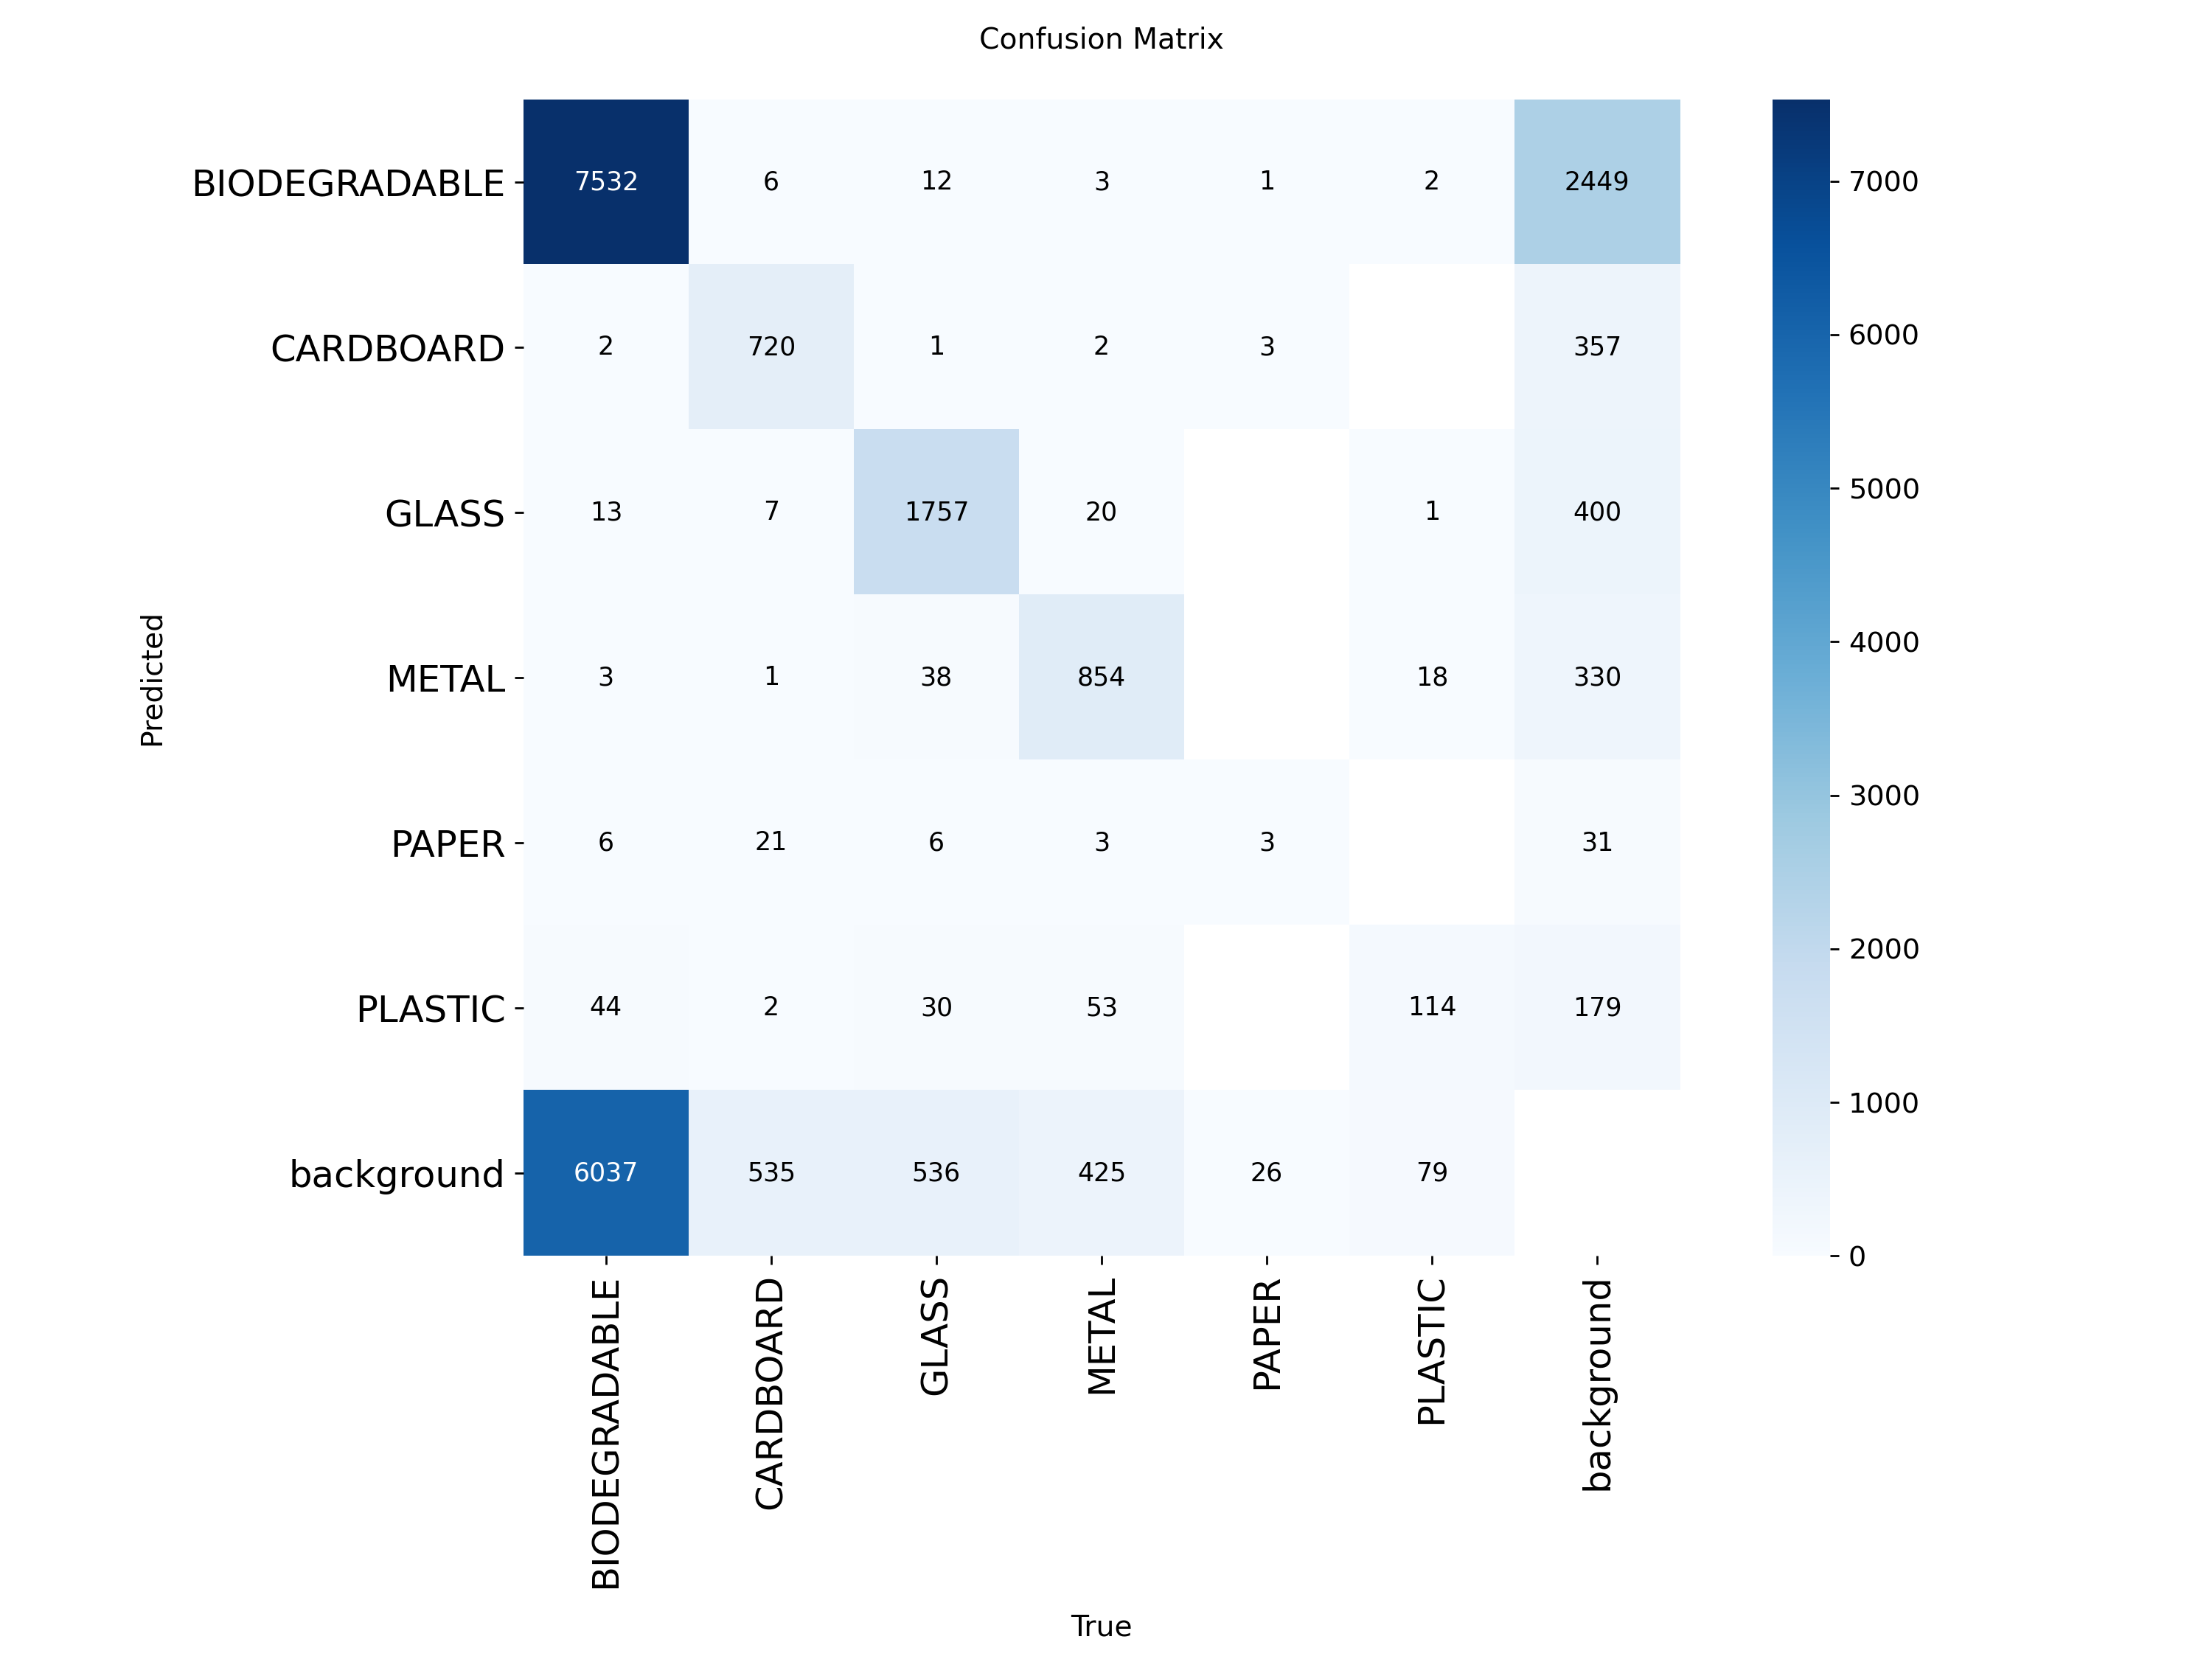

In [40]:
from IPython.display import Image, display
import os

# Ścieżki do plików graficznych (YOLO zapisuje je w folderze treningowym)
conf_matrix_poor = "GARBAGE CLASSIFICATION 3/runs/detect/train/confusion_matrix.png"
conf_matrix_good = "yolo11n run/runs/detect/train/confusion_matrix.png"

print("--- Macierz Pomyłek: Model A (Słaby) ---")
if os.path.exists(conf_matrix_poor):
    display(Image(filename=conf_matrix_poor, width=600))
else:
    print("Nie znaleziono pliku macierzy dla Modelu A.")

print("\n--- Macierz Pomyłek: Model B (Dobry) ---")
if os.path.exists(conf_matrix_good):
    display(Image(filename=conf_matrix_good, width=600))
else:
    print("Nie znaleziono pliku macierzy dla Modelu B.")

## 12. Porównanie wydajności (Inference Time)
Analiza czasu przetwarzania pojedynczego obrazu.
*Uwaga: Poniższe pomiary zostały wykonane na tym samym urządzeniu (CPU Apple M1 Pro), co pozwala na bezpośrednie porównanie "ciężkości" obliczeniowej obu modeli.*

In [41]:
import pandas as pd

# 1. Pobranie słowników z czasami (w ms) z ostatnich predykcji
# Upewnij się, że zmienne results_poor i results_good istnieją (z sekcji 7)
speed_a = results_poor[0].speed
speed_b = results_good[0].speed

# 2. Przygotowanie danych do tabeli
data = {
    "Etap przetwarzania": ["Preprocess (Przygotowanie)", "Inference (Wnioskowanie)", "Postprocess (Wynik)", "ŁĄCZNIE"],
    "Model A (Słaby) [ms]": [
        speed_a['preprocess'],
        speed_a['inference'],
        speed_a['postprocess'],
        sum(speed_a.values())
    ],
    "Model B (Dobry) [ms]": [
        speed_b['preprocess'],
        speed_b['inference'],
        speed_b['postprocess'],
        sum(speed_b.values())
    ]
}

# 3. Stworzenie i wyświetlenie dataframe
df = pd.DataFrame(data)

# Dodanie wiersza z różnicą (ile razy wolniejszy jest Model B)
total_a = sum(speed_a.values())
total_b = sum(speed_b.values())
ratio = total_b / total_a if total_a > 0 else 0

print(f"Rozdzielczość wejściowa Modelu A: {results_poor[0].orig_shape}")
print(f"Rozdzielczość wejściowa Modelu B: {results_good[0].orig_shape}")
print(f"-> Model B jest ok. {ratio:.1f}x wolniejszy od Modelu A.")
print("-" * 60)

# Wyświetlenie ładnej tabeli w Notebooku
display(df.round(2))

Rozdzielczość wejściowa Modelu A: (1000, 636)
Rozdzielczość wejściowa Modelu B: (1000, 636)
-> Model B jest ok. 2.4x wolniejszy od Modelu A.
------------------------------------------------------------


,Etap przetwarzania,Model A (Słaby) [ms],Model B (Dobry) [ms]
0,Preprocess (Przygotowanie),2.41,3.12
1,Inference (Wnioskowanie),14.64,40.60
2,Postprocess (Wynik),2.10,1.51
3,ŁĄCZNIE,19.15,45.23


## 13. Dobór progu pewności i analiza precyzji (F1 & PR Curves)

Poniższe wykresy (wygenerowane automatycznie przez YOLO) pozwalają ocenić jakość modelu B w zależności od przyjętego progu pewności (confidence threshold).

- **Krzywa F1:** Pokazuje harmoniczną średnią precyzji i czułości. Szczyt krzywej wskazuje optymalny próg `conf`, który warto ustawić na produkcji.
- **Krzywa PR:** Obrazuje ogólną zdolność modelu do poprawnej klasyfikacji (im większe pole pod wykresem, tym lepiej).

--- Analiza dla Modelu B (Najlepszego) ---


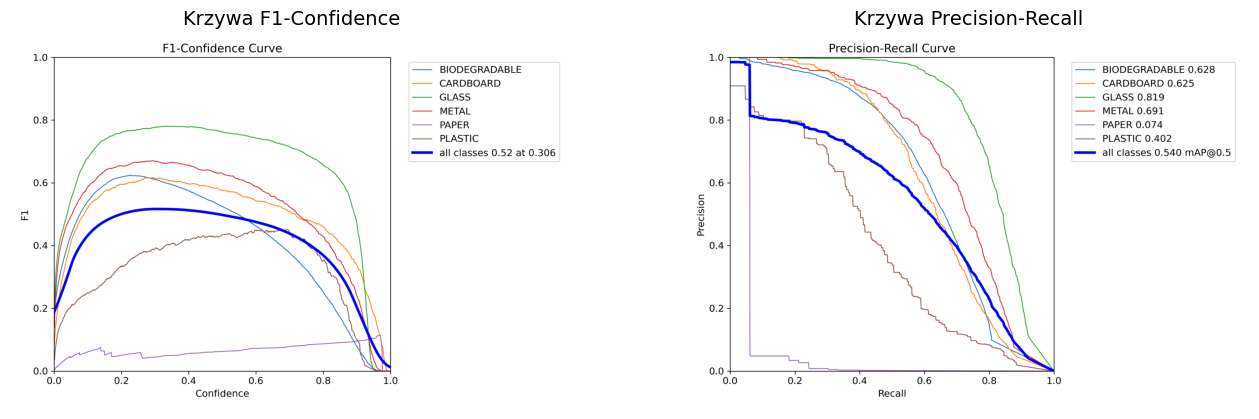

In [42]:
# Ścieżki do plików (tylko dla Modelu B-bo to on jest "kandydatem" do wdrożenia)
base_dir = "yolo11n run/runs/detect/train"
f1_path = os.path.join(base_dir, "BoxF1_curve.png")
pr_path = os.path.join(base_dir, "BoxPR_curve.png")

# Funkcja do wyświetlania obok siebie
def show_curves(path1, path2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    if os.path.exists(path1):
        img1 = mpimg.imread(path1)
        axes[0].imshow(img1)
        axes[0].set_title("Krzywa F1-Confidence", fontsize=14)
        axes[0].axis('off')
    else:
        axes[0].text(0.5, 0.5, "Brak pliku F1_curve.png", ha='center')

    if os.path.exists(path2):
        img2 = mpimg.imread(path2)
        axes[1].imshow(img2)
        axes[1].set_title("Krzywa Precision-Recall", fontsize=14)
        axes[1].axis('off')
    else:
        axes[1].text(0.5, 0.5, "Brak pliku PR_curve.png", ha='center')

    plt.show()

print("--- Analiza dla Modelu B (Najlepszego) ---")
show_curves(f1_path, pr_path)

## 14. Podsumowanie i Wnioski Końcowe

Na podstawie przeprowadzonych eksperymentów i analizy porównawczej modeli YOLO11n, sformułowano następujące wnioski:

### 1. Jakość danych i czas treningu (Quality & Epochs)
Jakość danych treningowych oraz długość procesu uczenia mają krytyczny wpływ na wyniki.
* **Model A (Słaby):** Trenowany krótko na małych obrazach (240px) wykazuje **bardzo niski recall** i tendencję do "hallucinogenic" obiektów (np. wykrywanie 2 obiektów tam, gdzie jest 1).
* **Model B (Dobry):** Dłuższy trening na obrazach 640px pozwolił na osiągnięcie wysokiej stabilności i poprawnej generalizacji.

### 2. Analiza kompromisu: Szybkość kontra Jakość (Speed-Accuracy Trade-off)
Zauważono istotną zależność między rozdzielczością wejściową a czasem inferencji (mierzone na Apple M1 Pro):
* **Model A** jest bardzo szybki (**~13 ms**), ale jego użyteczność jest znikoma z powodu błędów.
* **Model B** jest ok. **3-krotnie wolniejszy (~38 ms)**, co wynika z konieczności przetworzenia znacznie większej liczby pikseli (640 × 640), jednak oferuje akceptowalną precyzję.

### 3. Analiza błędów (Confusion Matrix)
Analiza macierzy pomyłek wykazała, że Model A ma trudności z rozróżnianiem tła/papieru od innych obiektów (wysoki wskaźnik False Positives/False Negatives), podczas gdy Model B skutecznie separuje klasy odpadów.

### 4. Rekomendacja
Do zastosowań praktycznych (np. w systemie sortowania odpadów) **bezwzględnie rekomendowany jest Model B**.
Mimo wyższego kosztu obliczeniowego, jest to jedyny model zapewniający wiarygodność detekcji. Model A, mimo szybkości, nie spełnia minimalnych wymogów biznesowych (błędna klasyfikacja odpadów jest kosztem nieakceptowalnym).